In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

## code is used to display all the datasets and not just part of it
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize


import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier


**Preprocessing (transforming and scaling) the datasets**

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

print(f"Length of training data: {len(train)}")
print(f"Length of testing data: {len(test)}")

Length of training data: 175341
Length of testing data: 82332


<Axes: >

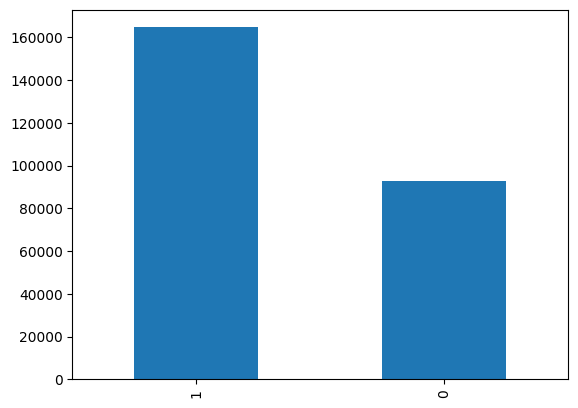

In [ ]:
combined_data['label'].value_counts().plot.bar()

In [ ]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

# if contamination > 0.5:
#     print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
#     contamination = round(1-contamination,2)
#     print(f'contamination is now {contamination}')

train contamination  0.68
test  contamination  0.55 



In [ ]:
combined_data.describe(include='all')
# combined_data.info()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673,257673.000000
unique,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93000,NaN
mean,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,...,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,NaN,0.639077
std,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,...,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,NaN,0.480269
min,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,...,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,NaN,1.000000


In [ ]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")

attack cat: {'Shellcode', 'Worms', 'DoS', 'Backdoor', 'Reconnaissance', 'Fuzzers', 'Analysis', 'Normal', 'Generic', 'Exploits'}

Describing attack_type: 
min 0
max 9
mode 0    6
Name: attack_cat, dtype: int64 Which is, ['Normal']
mode 0.3609225646458884 %


In [ ]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])
combined_data.head(5)

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,6,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,6,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,6,0


In [ ]:
## OMITTED: For statistical feature removal

lowSTD = list(combined_data.std().to_frame().nsmallest(6, columns=0).index)

# this is not cool. suppose a feature has a 1.0 (spearman or pearson) correlation, OR conditional probability, when not 0.... That's a very useful feature

lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(3).index) # .where(lambda x: x < 0.005).dropna()
# This might not be cool. Deep MLP (feed forward neural net) may see patterns

drop = set( lowCORR + lowSTD)
drop = {'ackdat', 'ct_ftp_cmd', 'djit', 'is_ftp_login', 'is_sm_ips_ports', 'response_body_len', 'sjit', 'synack', 'tcprtt'}
print(f'Before {combined_data.shape}')
combined_data_reduced=combined_data.drop(drop, axis=1) # .drop(drop,axis=1)
print(f'After {combined_data_reduced.shape}')

Before (257673, 44)
After (257673, 35)


### Splitting datasets into

In [ ]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]
# del combined_data # free mem
X_train, X_val_test, y_train, y_val_test = train_test_split(data_x, data_y, test_size=.40, random_state=42) # TODO
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = .2, random_state = 40)


In [ ]:
print("-----Print the the shapes of the various data splits--------")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {X_train.shape}")

## Print the Val_test sets
print(X.shape, y.shape)

## Splitting the val_test sets into val and test sets
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


-----Print the the shapes of the various data splits--------
X_train: (629145, 74)
Y_train: (629145, 74)
(419430, 74) (419430, 1)
X_val: (335544, 74)
y_val: (335544, 1)
X_test: (83886, 74)
y_test: (83886, 1)


### Training and evaluating models before feature removal

In [ ]:
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500, n_jobs=-1) # multiclass
# SVM = svm.SVC(random_state=42, decision_function_shape='ovo')
# KNN = KNeighborsClassifier(n_neighbors='10')

list_of_CLFs_names = []
list_of_CLFs = [RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_val,y_val)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.94973 for the RandomForestClassifier
Acc: 0.94783 for the ExtraTreesClassifier
Acc: 0.94812 for the XGBClassifier
[LightGBM] [Info] Number of positive: 98764, number of negative: 55839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4641
[LightGBM] [Info] Number of data points in the train set: 154603, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638823 -> initscore=0.570261
[LightGBM] [Info] Start training from score 0.570261
Acc: 0.95028 for the LGBMClassifier


In [ ]:
RFC.score(X_test, y_test)

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

0.9519258756185117

Acc: 0.95193 for the RandomForestClassifier
Acc: 0.94950 for the ExtraTreesClassifier
Acc: 0.94979 for the XGBClassifier
[LightGBM] [Info] Number of positive: 98764, number of negative: 55839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4641
[LightGBM] [Info] Number of data points in the train set: 154603, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638823 -> initscore=0.570261
[LightGBM] [Info] Start training from score 0.570261
Acc: 0.95159 for the LGBMClassifier


In [ ]:
from sklearn.metrics import classification_report

RFC = RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=5, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=5, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators=20, n_jobs=-1)

list_of_CLFs_names = []
list_of_CLFs = [RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Model:", name)

    # Calculate accuracy
    accuracy = clf.score(X_val, y_val)
    print("Accuracy:", accuracy)

    # Calculate precision, recall, and F1-score
    report = classification_report(y_val, pred)
    print("Classification Report:\n", report)

    ranking.append(accuracy)
    list_of_CLFs_names.append(name)

Model: RandomForestClassifier
Accuracy: 0.9998360870705482
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    244145
           1       1.00      1.00      1.00     91399

    accuracy                           1.00    335544
   macro avg       1.00      1.00      1.00    335544
weighted avg       1.00      1.00      1.00    335544

Model: ExtraTreesClassifier
Accuracy: 0.9999701976491906
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    244145
           1       1.00      1.00      1.00     91399

    accuracy                           1.00    335544
   macro avg       1.00      1.00      1.00    335544
weighted avg       1.00      1.00      1.00    335544

Model: XGBClassifier
Accuracy: 0.9999403952983812
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    244145